<a href="https://colab.research.google.com/github/anniettr/t2d_pred/blob/main/Pima_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.colab import drive, files

from sklearn.base import clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, classification_report

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
!

In [ ]:
# @title Loading Dataset - pima_diabetes_df

drive.mount('/content/drive')
pima_diabetes_df = pd.read_csv('/content/drive/My Drive/ECS_171_Project/diabetes.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis (EDA)


## Dataset Validation

In [ ]:
pima_diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
pima_diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
dataset_len = pima_diabetes_df.shape[0]
dataset_len

768

Dataset size consists of 768 rows - slightly small dataset

In [ ]:
pima_diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

No NULL values found

## Visualizing Attributes

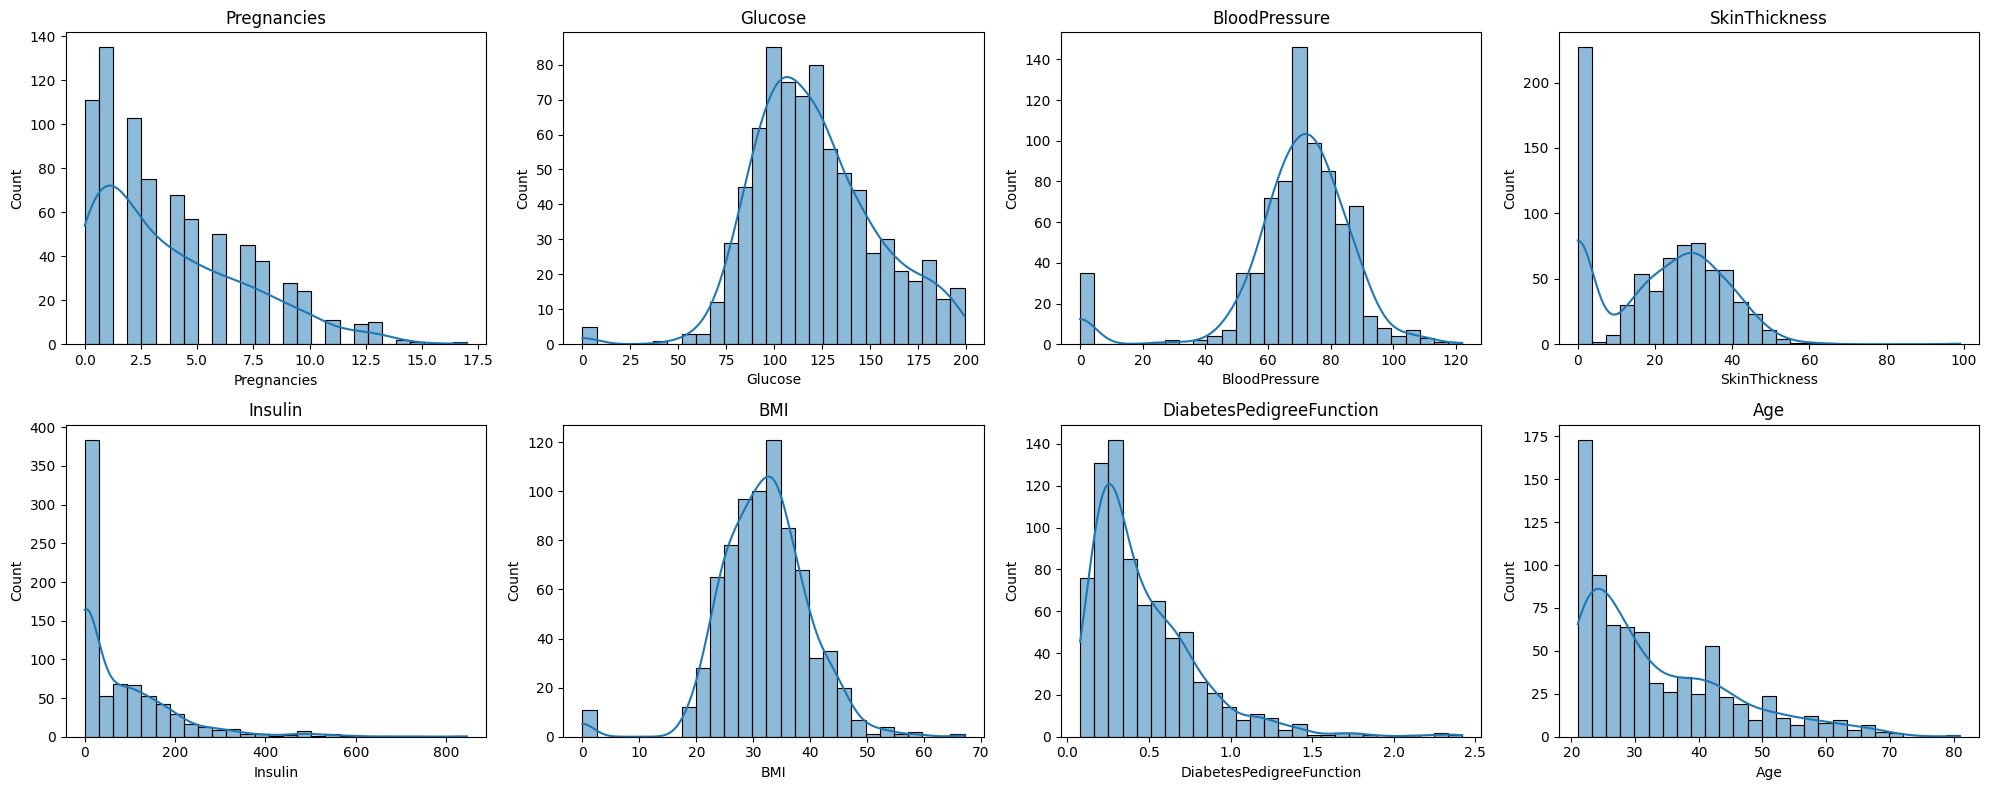

In [ ]:
# @title Histograms

plt.figure(figsize=(20, 8))

for i, col in enumerate(pima_diabetes_df.columns[:-1], 1):
  plt.subplot(2, int(len(pima_diabetes_df.columns) / 2), i)
  sns.histplot(pima_diabetes_df[col], bins=int(np.sqrt(dataset_len)), kde=True)
  plt.title(col)

plt.tight_layout()
plt.show()

In [ ]:
# @title Mean, Median, and Standard Deviation

for col in pima_diabetes_df.columns[:-1]:
  print("{}\n Mean: {}\n Median: {}\n STD: {}\n".format(col, pima_diabetes_df[col].mean(), pima_diabetes_df[col].median(), pima_diabetes_df[col].std()))

Pregnancies
 Mean: 3.8450520833333335
 Median: 3.0
 STD: 3.3695780626988694

Glucose
 Mean: 120.89453125
 Median: 117.0
 STD: 31.97261819513622

BloodPressure
 Mean: 69.10546875
 Median: 72.0
 STD: 19.355807170644777

SkinThickness
 Mean: 20.536458333333332
 Median: 23.0
 STD: 15.952217567727637

Insulin
 Mean: 79.79947916666667
 Median: 30.5
 STD: 115.24400235133817

BMI
 Mean: 31.992578124999998
 Median: 32.0
 STD: 7.884160320375446

DiabetesPedigreeFunction
 Mean: 0.47187630208333325
 Median: 0.3725
 STD: 0.3313285950127749

Age
 Mean: 33.240885416666664
 Median: 29.0
 STD: 11.760231540678685



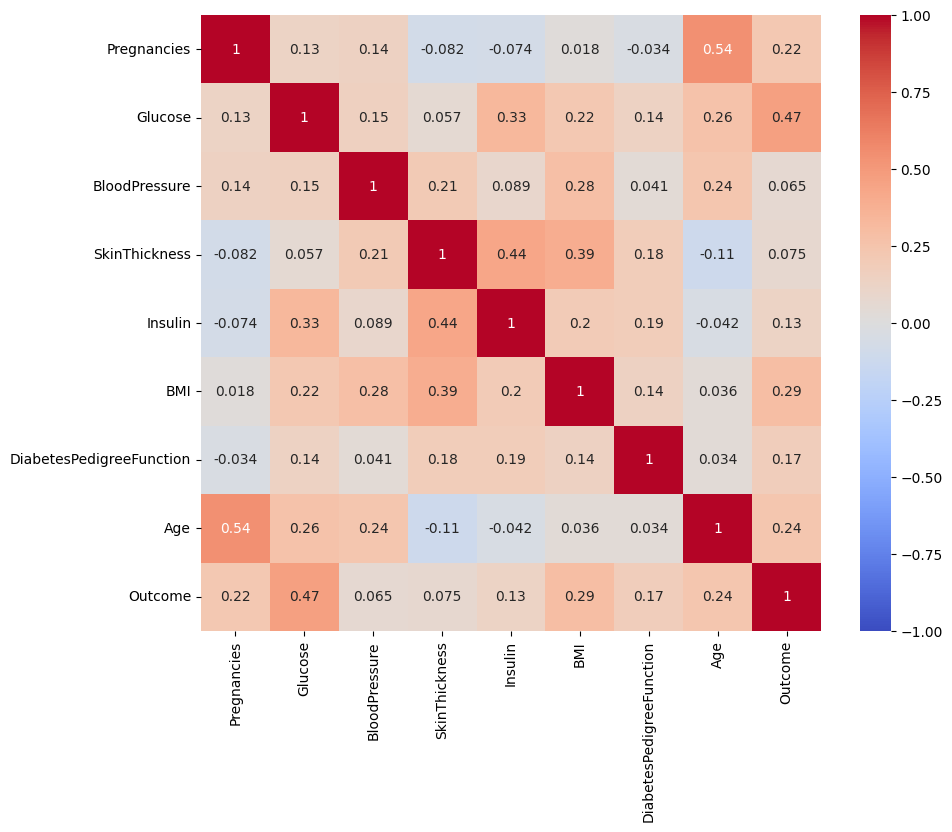

In [ ]:
# @title Visualizing Coefficient Matrix
plt.figure(figsize=(10,8))
heat = sns.heatmap(pima_diabetes_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

The correlation coefficient shown in the heatmap identifies the strength of association between two variables. The value of the correlation coefficient can be between -1 to +1 with +1 meaning strong positive correlation, 0 meaning no correlation, and -1 meaning strong negative correlation.

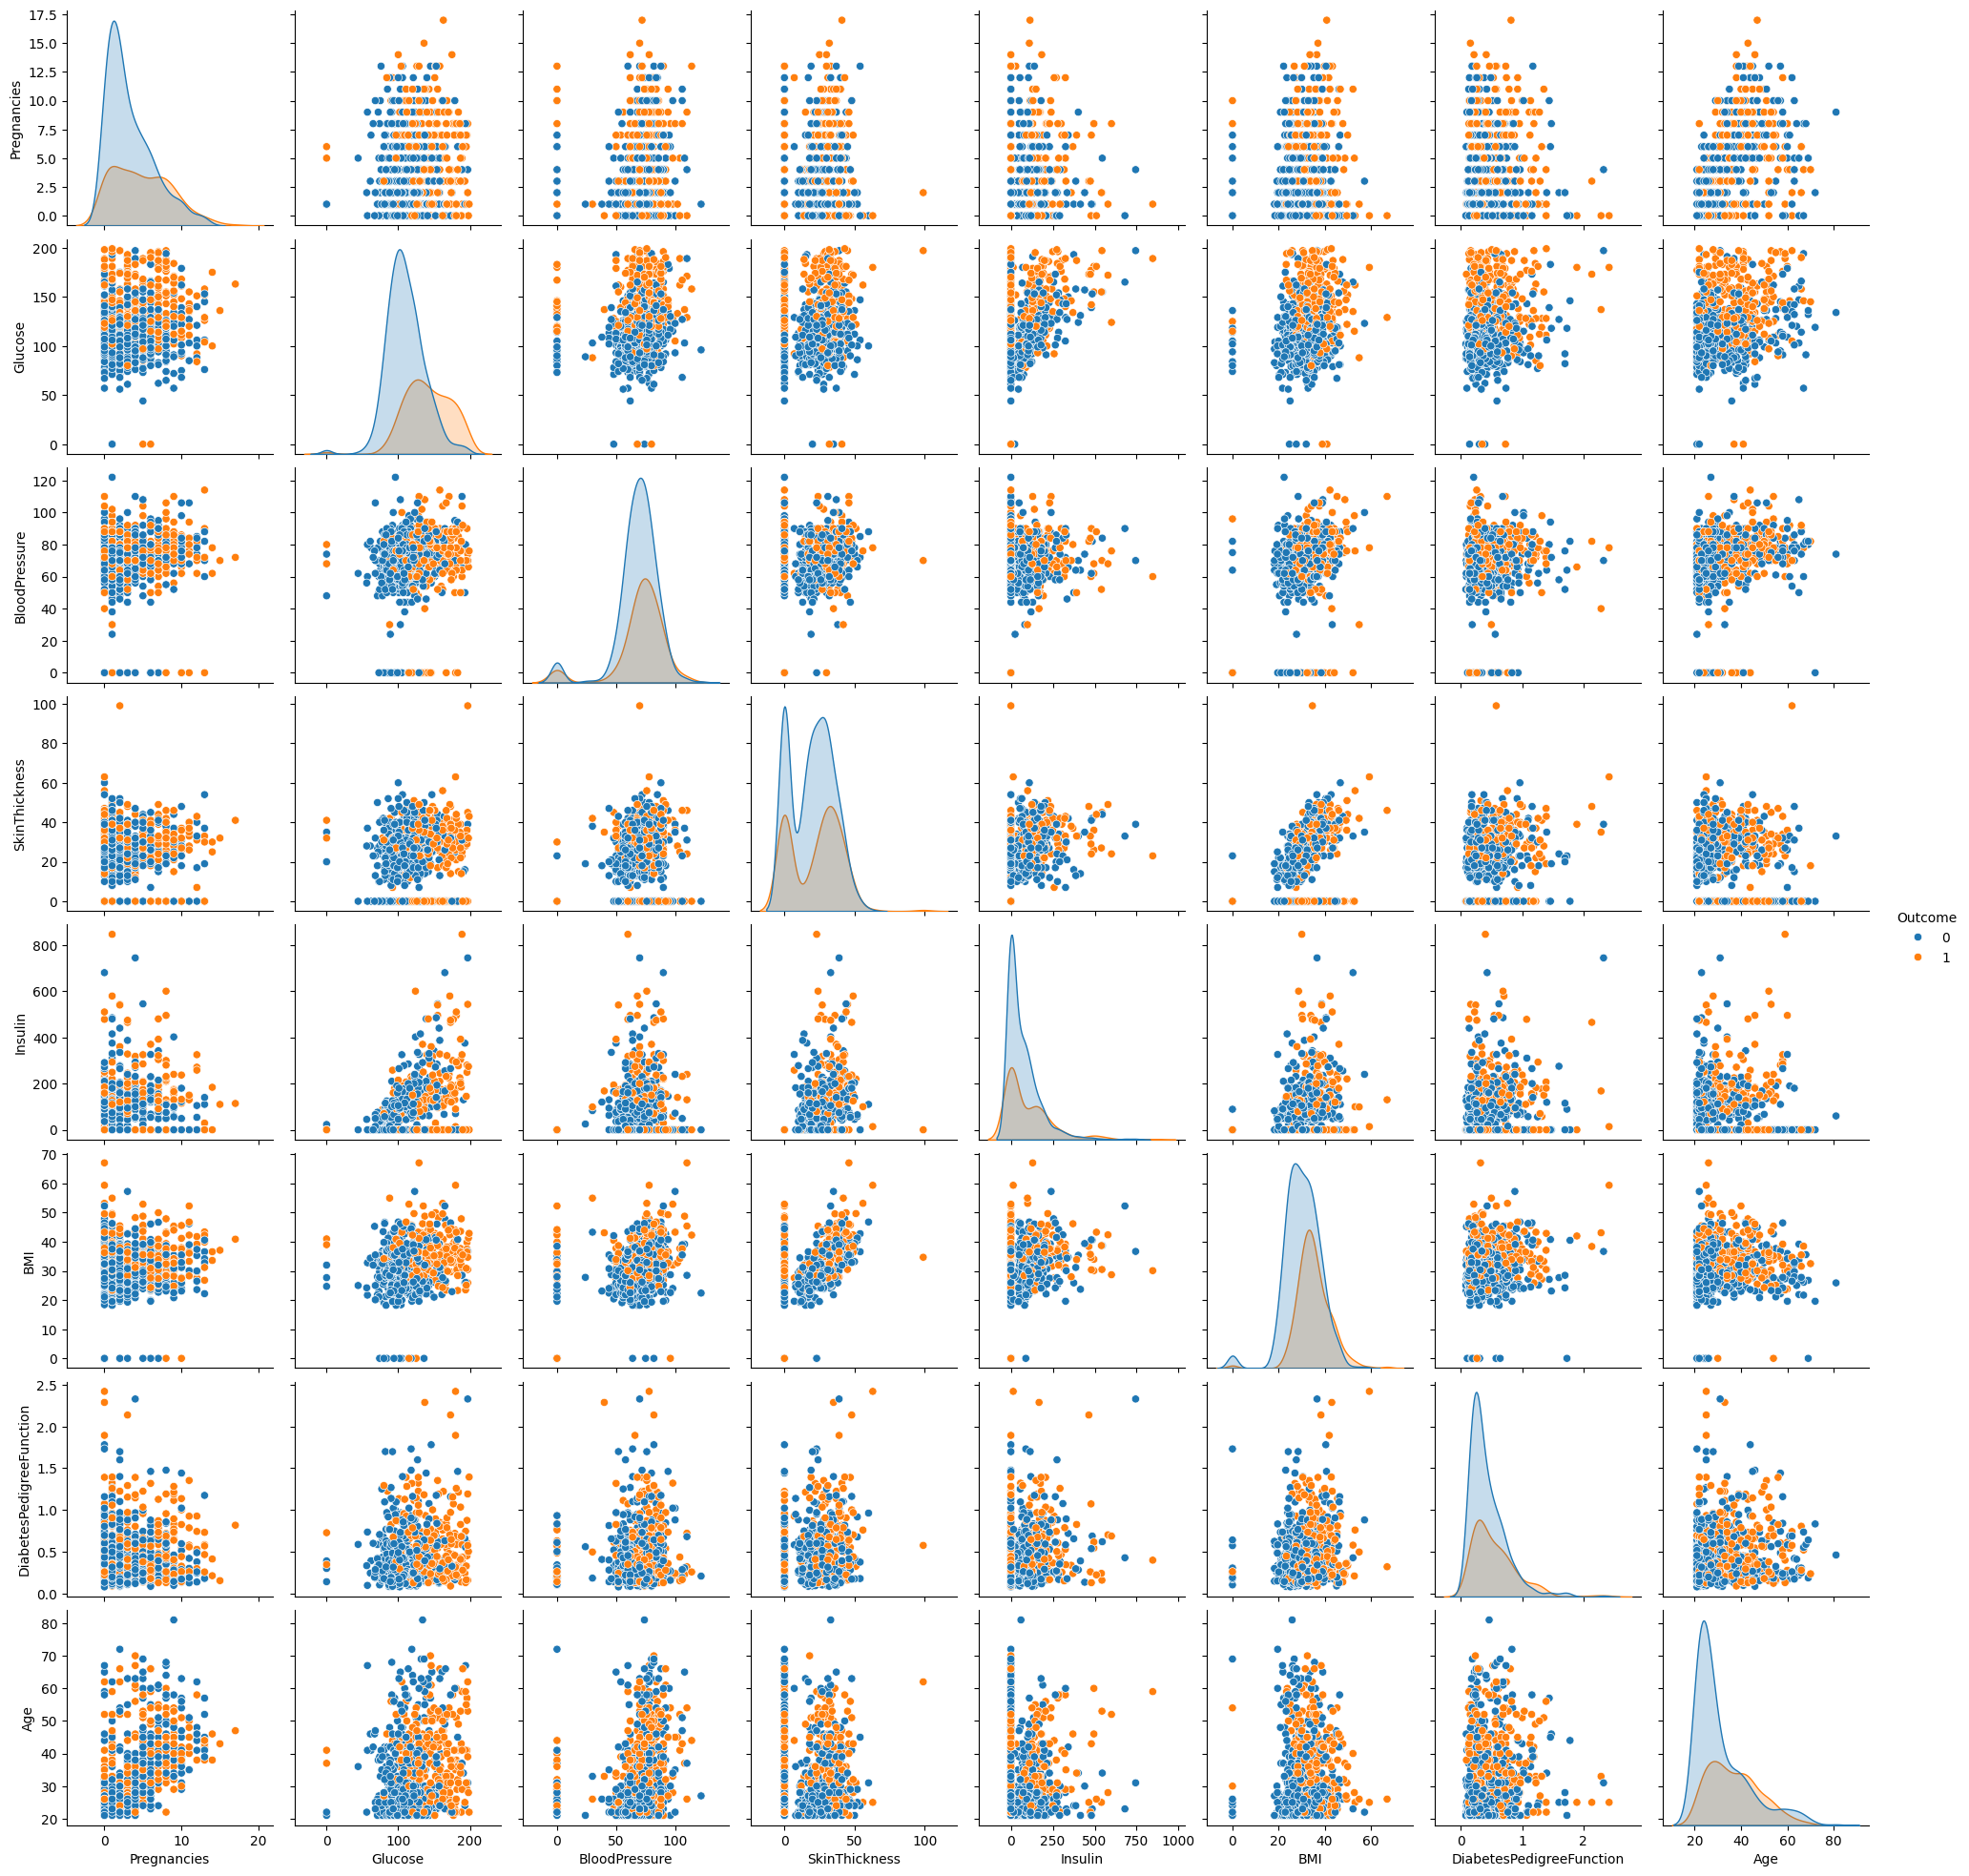

In [ ]:
scatter = sns.pairplot(pima_diabetes_df, hue='Outcome')

## Visualizing Target

Outcome
0    500
1    268
Name: count, dtype: int64


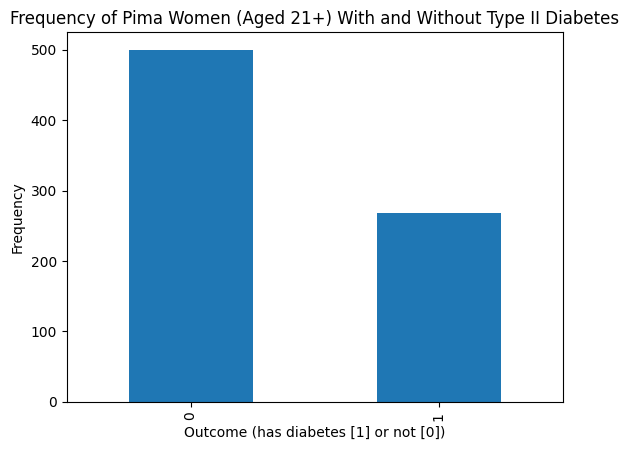

In [ ]:
print(pima_diabetes_df["Outcome"].value_counts())

pima_diabetes_df["Outcome"].value_counts().plot(kind="bar")
plt.xlabel("Outcome (has diabetes [1] or not [0])")
plt.ylabel("Frequency")
plt.title("Frequency of Pima Women (Aged 21+) With and Without Type II Diabetes")
plt.show()

Target - binary classified values of 0 and 1 (double the number of 0s)

## Visualizing Outliers

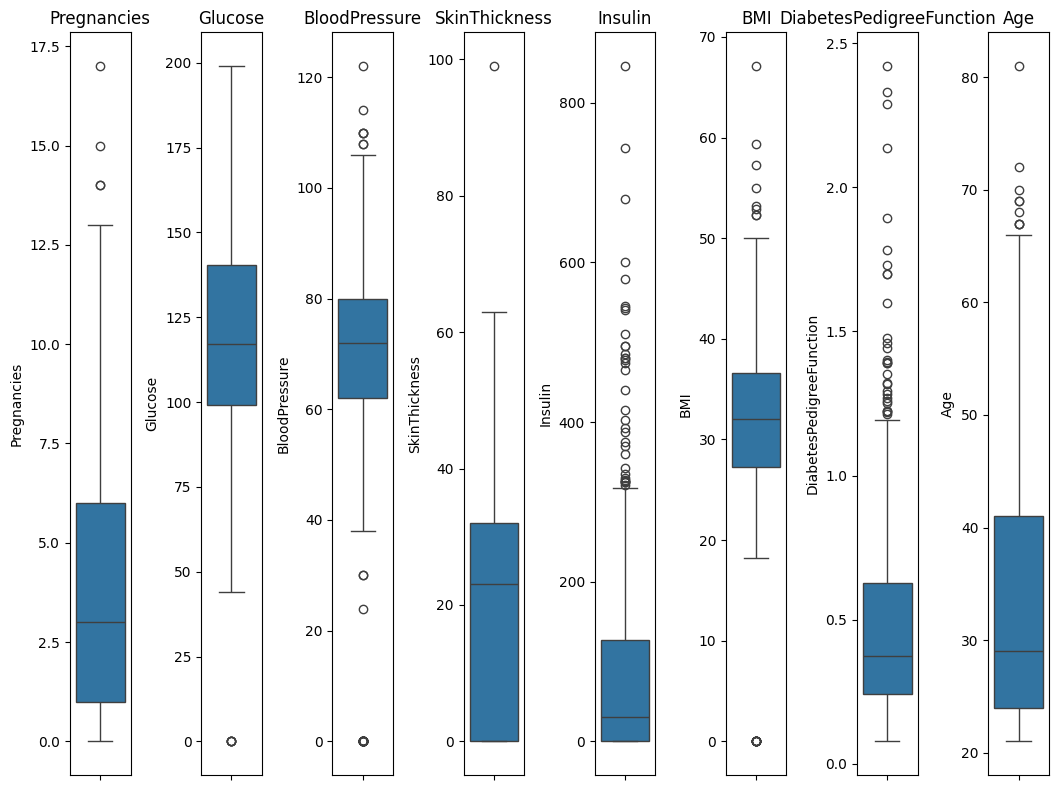

In [ ]:
# @title Boxplots

plt.figure(figsize=(12, 8))

for i, col in enumerate(pima_diabetes_df.columns[:-1], 1):
  plt.subplot(1, len(pima_diabetes_df.columns), i)
  sns.boxplot(y=pima_diabetes_df[col])
  plt.title(col)

plt.subplots_adjust(wspace=0)  # Adjust the value of wspace to increase or decrease spacing
plt.tight_layout()
plt.show()

In [ ]:
# @title Computing with IQR

for col in pima_diabetes_df.columns[:-1]:
  Q1 = pima_diabetes_df[col].quantile(0.25)
  Q3 = pima_diabetes_df[col].quantile(0.75)
  IQR = Q3 - Q1
  outliers = pima_diabetes_df[(pima_diabetes_df[col] < (Q1 - 1.5 * IQR)) | (pima_diabetes_df[col] > (Q3 + 1.5 * IQR))]
  print(f"Number of Outliers for Attribute '{col}': {len(outliers)}")
  # print("Outliers for {}: \n{}".format(col, outliers))

Number of Outliers for Attribute 'Pregnancies': 4
Number of Outliers for Attribute 'Glucose': 5
Number of Outliers for Attribute 'BloodPressure': 45
Number of Outliers for Attribute 'SkinThickness': 1
Number of Outliers for Attribute 'Insulin': 34
Number of Outliers for Attribute 'BMI': 19
Number of Outliers for Attribute 'DiabetesPedigreeFunction': 29
Number of Outliers for Attribute 'Age': 9


In [ ]:
# @title Isolation Forest

from sklearn.ensemble import IsolationForest

for i, attribute in enumerate(pima_diabetes_df.columns[:-1]):
  # get dataset
  X = pima_diabetes_df[attribute].values

  # initialize model
  contamination = 'auto' #@param {input:"raw"}
  iso_forest = IsolationForest(random_state=42, contamination=contamination) # random state as 42 just for fun :)

  # predict outlier scores of dataset
  scores = iso_forest.fit_predict(X.reshape(-1,1))

  # get inliers and outliers
  num_inliers = np.sum(scores == 1)
  num_outliers = np.sum(scores == -1)

  print(f"Outlier Predictions for Attribute '{attribute}':")
  print(f"\tNumber of Inliers: {num_inliers}")
  print(f"\tNumber of Outliers: {num_outliers}")

Outlier Predictions for Attribute 'Pregnancies':
	Number of Inliers: 381
	Number of Outliers: 387
Outlier Predictions for Attribute 'Glucose':
	Number of Inliers: 558
	Number of Outliers: 210
Outlier Predictions for Attribute 'BloodPressure':
	Number of Inliers: 624
	Number of Outliers: 144
Outlier Predictions for Attribute 'SkinThickness':
	Number of Inliers: 568
	Number of Outliers: 200
Outlier Predictions for Attribute 'Insulin':
	Number of Inliers: 645
	Number of Outliers: 123
Outlier Predictions for Attribute 'BMI':
	Number of Inliers: 647
	Number of Outliers: 121
Outlier Predictions for Attribute 'DiabetesPedigreeFunction':
	Number of Inliers: 638
	Number of Outliers: 130
Outlier Predictions for Attribute 'Age':
	Number of Inliers: 432
	Number of Outliers: 336


In [ ]:
# @title One-Class SVM

from sklearn.svm import OneClassSVM

for i, attribute in enumerate(pima_diabetes_df.columns[:-1]):
  # get dataset
  X = pima_diabetes_df[attribute].values

  # initialize model with default parameters (maybe change this later)
  oc_svm = OneClassSVM()

  # predict outlier scores of dataset
  scores = oc_svm.fit_predict(X.reshape(-1,1))

  # get inliers and outliers
  num_inliers = np.sum(scores == 1)
  num_outliers = np.sum(scores == -1)

  print(f"Outlier Predictions for Attribute '{attribute}':")
  print(f"\tNumber of Inliers: {num_inliers}")
  print(f"\tNumber of Outliers: {num_outliers}")

Outlier Predictions for Attribute 'Pregnancies':
	Number of Inliers: 390
	Number of Outliers: 378
Outlier Predictions for Attribute 'Glucose':
	Number of Inliers: 381
	Number of Outliers: 387
Outlier Predictions for Attribute 'BloodPressure':
	Number of Inliers: 410
	Number of Outliers: 358
Outlier Predictions for Attribute 'SkinThickness':
	Number of Inliers: 546
	Number of Outliers: 222
Outlier Predictions for Attribute 'Insulin':
	Number of Inliers: 175
	Number of Outliers: 593
Outlier Predictions for Attribute 'BMI':
	Number of Inliers: 372
	Number of Outliers: 396
Outlier Predictions for Attribute 'DiabetesPedigreeFunction':
	Number of Inliers: 387
	Number of Outliers: 381
Outlier Predictions for Attribute 'Age':
	Number of Inliers: 369
	Number of Outliers: 399


# Preprocessing

### Finding Invalid Values

In [ ]:
# Pregnancies - None

# Glucose
invalid_glucose = pima_diabetes_df.index[pima_diabetes_df['Glucose'] < 1].tolist() # some values between 50-60, ignore and imputate zeros
print("Glucose",':',len(invalid_glucose))

# Blood Pressure
invalid_blood_pressure = pima_diabetes_df.index[pima_diabetes_df['BloodPressure'] < 1].tolist() # some values between 30-40, ignore and imputate zeros
print("Blood Pressure",':',len(invalid_blood_pressure))

# Skin Thickness (Tricep)
invalid_skin_thickness = pima_diabetes_df.index[pima_diabetes_df['SkinThickness'] < 2].tolist() # all invalid are zeros
print("Skin Thickness",':',len(invalid_skin_thickness))

# Insulin - Avg between 2-25
invalid_insulin = pima_diabetes_df.index[pima_diabetes_df['Insulin'] < 2].tolist() # all invalid are zeros
print("Insulin",':',len(invalid_insulin))

# BMI
invalid_bmi = pima_diabetes_df.index[pima_diabetes_df['BMI'] < 2].tolist() # all invalid are zeros
print("BMI",':',len(invalid_bmi))

# Diabetes Pedigree Function - None

# Age - None

Glucose : 5
Blood Pressure : 35
Skin Thickness : 227
Insulin : 374
BMI : 11


### Visualizing Valid Values

Glucose
 Mean: 121.6867627785059
 Median: 117.0
 STD: 30.535641072804033

BloodPressure
 Mean: 72.40518417462484
 Median: 72.0
 STD: 12.38215821010526

BMI
 Mean: 32.774121996303144
 Median: 32.8
 STD: 7.144264431974661



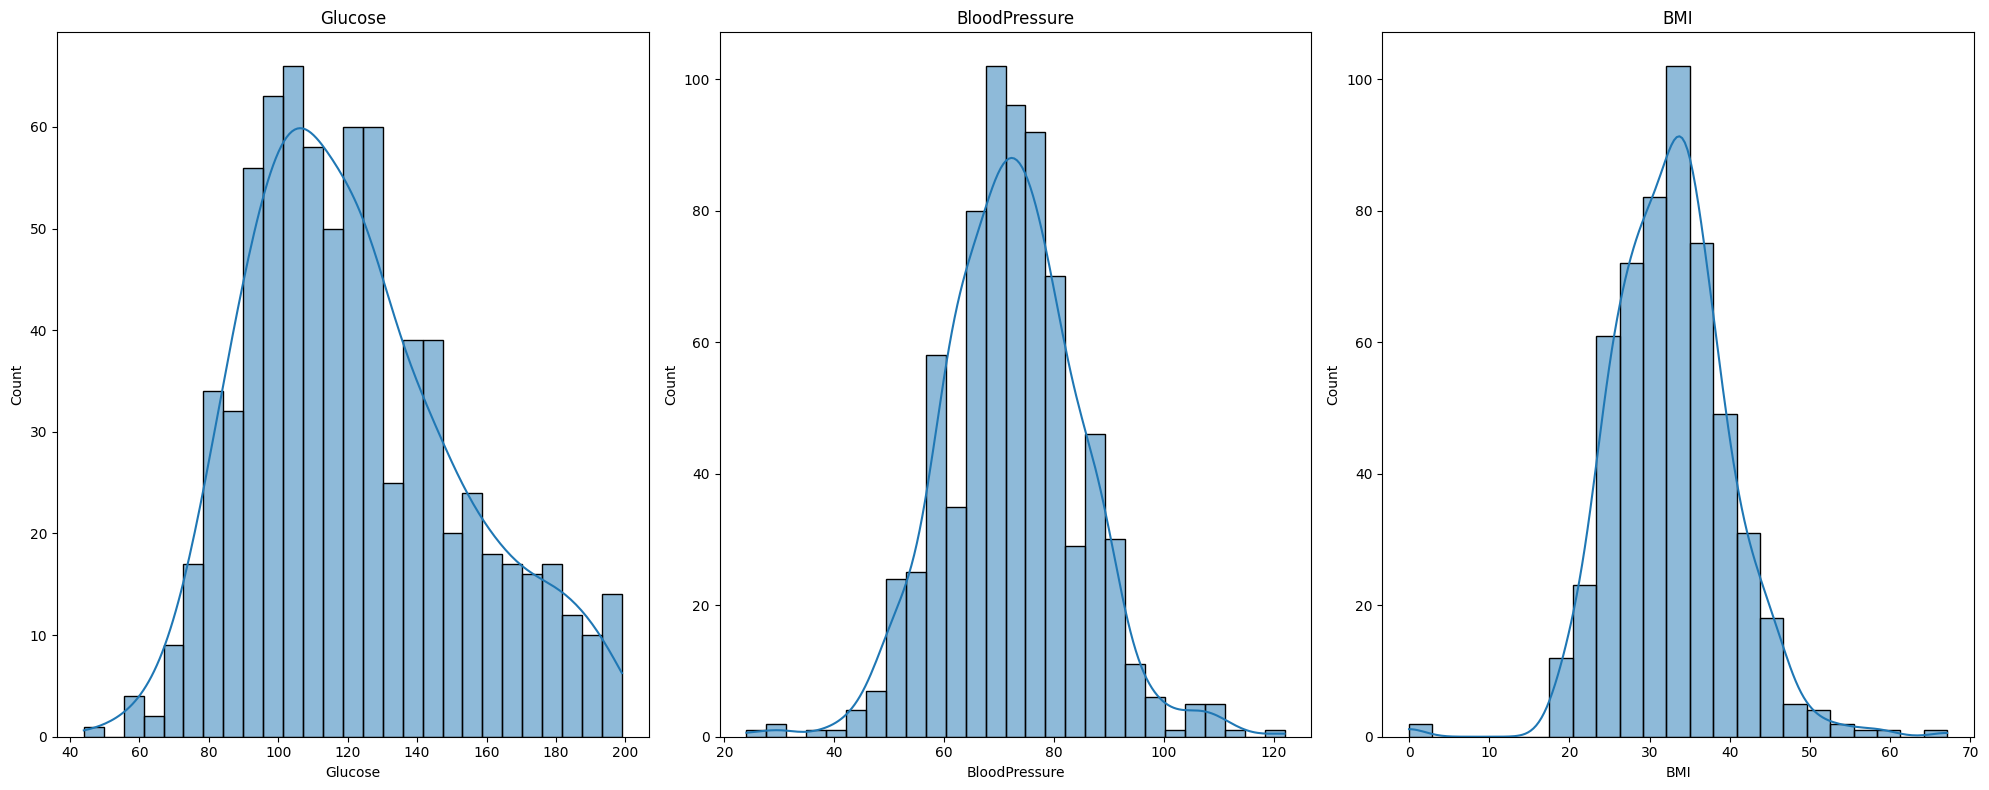

In [ ]:
plt.figure(figsize=(20,8))

invalid_cols = ["Glucose", "BloodPressure", "BMI"]
invalid_lists = [invalid_glucose, invalid_blood_pressure, invalid_skin_thickness, invalid_insulin, invalid_bmi]

for i, (col, invalid_list) in enumerate(zip(invalid_cols, invalid_lists), 1):
  plt.subplot(1, len(invalid_cols), i)
  valid_list = pima_diabetes_df.loc[~pima_diabetes_df.index.isin(invalid_list), col]
  sns.histplot(valid_list, bins=int(np.sqrt(len(valid_list))), kde=True)
  plt.title(col)

  print("{}\n Mean: {}\n Median: {}\n STD: {}\n".format(col, valid_list.mean(), valid_list.median(), valid_list.std()))

plt.tight_layout()
plt.show()

Distribution Analysis:
- Glucose: skewed to the right -> median or knn imputation
- Blood Pressure: fairly normalized -> mean imputation
- BMI: slightly skewed to the right -> knn, mean, or median imputation

Conduct a sensitivity analysis on the final model with regards to different imputation styles

## Dataset Trimming

### Removing Invalid Data From Dataset

In [ ]:
invalid_indices = set(invalid_glucose + invalid_blood_pressure + invalid_skin_thickness + invalid_insulin + invalid_bmi + invalid_bmi)
pima_only_valid_inputs_df = pima_diabetes_df.drop(invalid_indices)
print("Size of dataset after all invalid input values are removed:", len(pima_only_valid_inputs_df))
print(pima_only_valid_inputs_df)

Size of dataset after all invalid input values are removed: 392
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
6              3       78             50             32       88  31.0   
8              2      197             70             45      543  30.5   
13             1      189             60             23      846  30.1   
..           ...      ...            ...            ...      ...   ...   
753            0      181             88             44      510  43.3   
755            1      128             88             39      110  36.5   
760            2       88             58             26       16  28.4   
763           10      101             76             48      180  32.9   
765            5      121             72             23      112  26.2   

     DiabetesPedigreeFunction  Age  Outcome  
3

### Random Sampling (No Imputation)

In [ ]:
# sample 50 times
sampled_datasets = list()
total_sparsities = list()
col_sparsities = dict()
for col in pima_diabetes_df.columns:
  if col in {'Outcome', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies'}: continue
  col_sparsities[col] = list()

for i in range(50):
    sampled_df = pima_diabetes_df.sample(n=450, random_state=i)
    sampled_datasets.append(sampled_df)

    # calculate sparsities for the sampled sets
    total_vals = sampled_df.size
    total_missing = 0
    total_sparsity = 0

    for col in sampled_df.columns:
      if col in {'Outcome', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies'}: continue

      if col in {'Glucose', 'Blood Pressure'}:
        num_missing_vals = (sampled_df[col] < 1).sum().sum()
      else:
        num_missing_vals = (sampled_df[col] < 2).sum().sum()

      total_missing += num_missing_vals
      sparsity = num_missing_vals / sampled_df[col].size
      total_sparsity += sparsity

      col_sparsities[col].append(sparsity)

    total_sparsities.append(total_sparsity)

sampled_sparsity_df = pd.DataFrame(col_sparsities)

print(sampled_sparsity_df)

     Glucose  BloodPressure  SkinThickness   Insulin       BMI
0   0.006667       0.055556       0.317778  0.513333  0.013333
1   0.004444       0.044444       0.286667  0.462222  0.020000
2   0.006667       0.048889       0.291111  0.491111  0.015556
3   0.004444       0.046667       0.286667  0.471111  0.013333
4   0.004444       0.035556       0.293333  0.508889  0.002222
5   0.006667       0.048889       0.295556  0.482222  0.017778
6   0.006667       0.042222       0.277778  0.480000  0.011111
7   0.000000       0.037778       0.277778  0.477778  0.015556
8   0.006667       0.035556       0.293333  0.471111  0.015556
9   0.008889       0.044444       0.280000  0.475556  0.011111
10  0.004444       0.048889       0.308889  0.506667  0.013333
11  0.006667       0.042222       0.293333  0.468889  0.015556
12  0.008889       0.046667       0.326667  0.515556  0.006667
13  0.004444       0.048889       0.297778  0.475556  0.011111
14  0.002222       0.044444       0.282222  0.482222  0

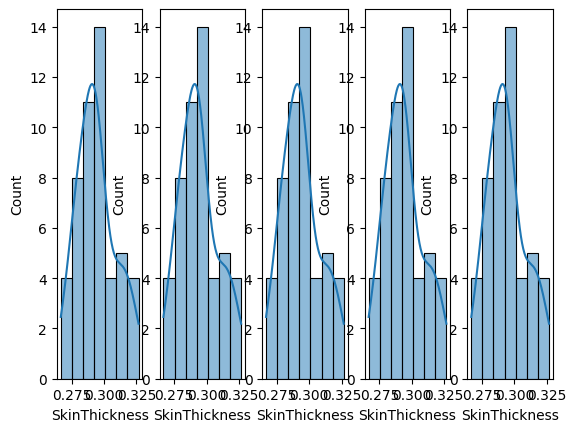

In [ ]:
plt.figure()
for i, col in enumerate(sampled_sparsity_df.columns):
  plt.subplot(1, len(sampled_sparsity_df.columns), i+1)
  sns.histplot(sampled_sparsity_df["SkinThickness"], bins=int(np.sqrt(len(sampled_sparsity_df["SkinThickness"]))), kde=True)

## Imputation

The following attributes are detected to contain entries valued at 0, which makes the associated data invalid:
- Glucose
- Blood Pressure
- Skin Thickness
- Insulin
- BMI

**NOTE:** Some features do not need imputation:
- Number of Pregnancies - can be zero -> unknown if missing values or not
- Diabetes Pedigree Function - ranges from 0.08 to 2.4 ([source](https://dergipark.org.tr/en/download/article-file/1970853#:~:text=The%20'DiabetesPedigreeFunction'%20is%20a%20function,1%20represents%20those%20with%20diabetes.))
- Age - all age values are within an expected range (21+)

Proposed methods:
- Mean is appropriate when the data is normally distributed, but if the data is heavily skewed then there may be bias towards outliers and won't represent the central tendency of the data
- Median is rebust to outliers and suitable for skewed distributions, but can lead to a loss of variability representation
- K-Nearest Neighbors (KNN) to approximate missing values (we have a small dataset so the computational expense could be negliigable)
- Conduct a sensitivity analysis on the model by testing different methods

**NOTE:** We originally considered Regression Imputation, but the nature of our dataset, wherein features lack strong correlations, has lead us to ignore this method

In [ ]:
print("Insulin:", len(invalid_insulin), 'invalid vs', dataset_len, '(', len(invalid_insulin)/dataset_len *100, '% )')
print("Skin Thickness:", len(invalid_skin_thickness), 'invalid vs', dataset_len,  '(', len(invalid_skin_thickness)/dataset_len *100, '% )')

Insulin: 374 invalid vs 768 ( 48.69791666666667 % )
Skin Thickness: 227 invalid vs 768 ( 29.557291666666668 % )


No Mean or Median Imputation will be done on 'Skin Thickness' and 'Insulin' atrributes due to high data sparsity. Instead we opt for KNN Imputation

In [ ]:
# @title Imputing invalid indices

valid_pima_df = pima_diabetes_df.copy() # new dataframe containing imputated values

# Glucose - median / knn
valid_pima_df.loc[valid_pima_df.index.isin(invalid_glucose), 'Glucose'] = np.median(valid_pima_df.loc[~valid_pima_df.index.isin(invalid_glucose), 'Glucose'])

# Blood Pressure - mean
valid_pima_df.loc[valid_pima_df.index.isin(invalid_blood_pressure), 'BloodPressure'] = np.mean(valid_pima_df.loc[~valid_pima_df.index.isin(invalid_blood_pressure), 'BloodPressure'])

# BMI - median / mean / knn
valid_pima_df.loc[valid_pima_df.index.isin(invalid_bmi), 'BMI'] = np.median(valid_pima_df.loc[~valid_pima_df.index.isin(invalid_bmi), 'BMI'])

### KNN Imputation

In [ ]:
# @title K-Folds Method

def get_best_model_from_kfold_cv(model, X, y, folds=4, standardize=False):
  """
  Returns the best model after K-Fold cross-validation.
  """

  num_folds = folds #@param {input:"integer"}
  kfold = KFold(num_folds)

  # store models and MSEs
  models = list()
  mses = list() # NOTE: we can change the evaluation function later this is just what we normally use so far

  for train_indices, test_indices in kfold.split(X):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    # standardize data
    if (standardize):
      scaler = StandardScaler()
      scaler.fit_transform(X_train)
      scaler.transform(X_test)

    # copy and train model
    cur_model = clone(model)
    cur_model.fit(X_train, y_train)

    # test model
    y_pred = cur_model.predict(X_test)

    # compute MSE score and append to lists
    models.append(cur_model)
    mses.append(mean_squared_error(y_test, y_pred))

  # obtain best model
  best_model_index = np.argmin(mses)
  return models[best_model_index], mses[best_model_index]

In [ ]:
# @title Function for Removing Specified Columns

def remove_cols(cols_to_remove, df=valid_pima_df):
  return df[[col for col in valid_pima_df.columns if col not in cols_to_remove]]

In [ ]:
# @title K-Nearest Neighbor Imputation on Skin Thickness and Insulin

"""
Skin Thickness:
Insulin:

get valid_list
fit knn on valid list
for each datapoint in invalid_list:
  set datapoint value to knn transformed datapoint

"""

def knn_on_invalid_feature(feature_names:list[str], df:pd.DataFrame):
  df = df.copy(deep=True)
  feature_prediction_mses = list()
  for feature_name in feature_names:
    # remove invalid skin thickness values for prediction
    knn_has_df_ = df[df[feature_name].astype(int) != 0]

    # get other features as input attributes
    X = remove_cols(feature_names + ["Outcome"], knn_has_df_).to_numpy()

    # get skin thickness as target
    y = knn_has_df_[feature_name].values

    # initialize parameters
    num_folds = 4 #@param {type:"integer"}
    num_neighbors = 7 #@param {type:"integer"}

    # get the best model for skin thickness prediction
    model, mse = get_best_model_from_kfold_cv(KNeighborsRegressor(n_neighbors=num_neighbors), X, y)
    feature_prediction_mses.append(mse)

    # predict invalid skin thickness values
    X_pred = remove_cols(["SkinThickness", "Insulin", "Outcome"], df[df[feature_name].astype(int) == 0]).to_numpy()
    y_pred = model.predict(X_pred)
    df.loc[df[feature_name].astype(int) == 0, feature_name] = y_pred

  return df, feature_prediction_mses

valid_pima_after_knn_df, mses = knn_on_invalid_feature(["SkinThickness", "Insulin"], valid_pima_df)
print(mses)


[63.567498110355245, 8888.427530195753]


## Post Imputation Analysis

In [ ]:
# @title Original DataFrame

pima_diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# @title Imputed DataFrame

valid_pima_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.405184,20.536458,79.799479,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096346,15.952218,115.244002,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,0.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,0.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,23.000000,30.500000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


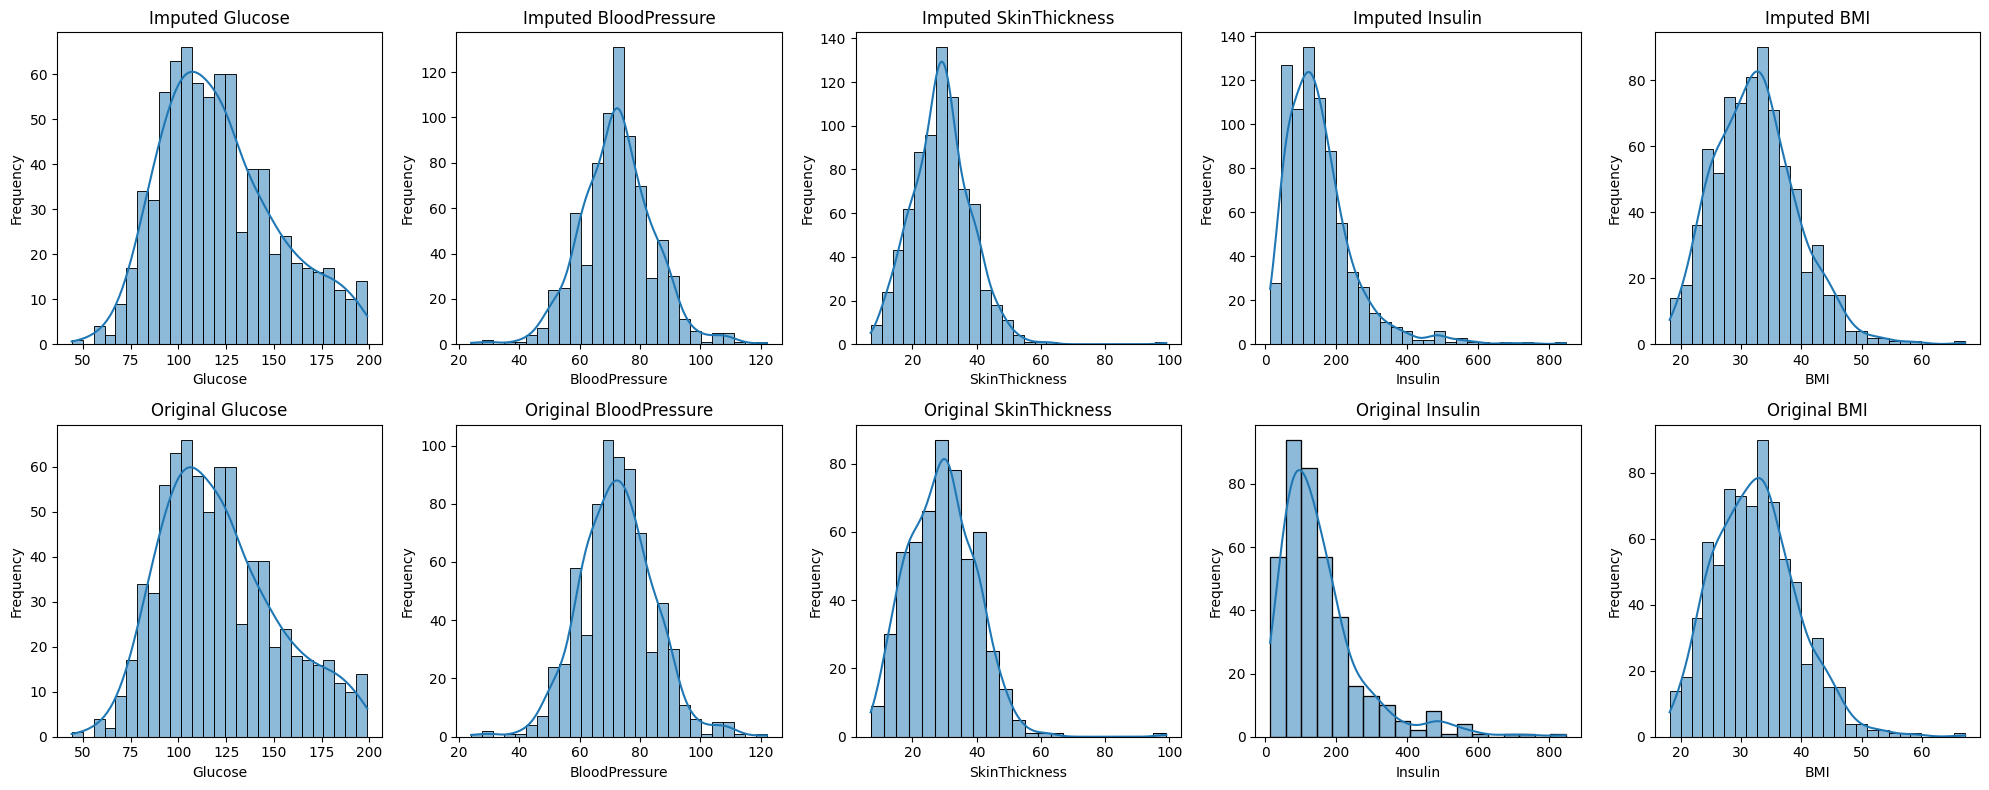

In [ ]:
# @title Visualizing Imputated Data Distributions vs Original Distributions

plt.figure(figsize=(20,8))

invalid_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
invalid_lists = [invalid_glucose, invalid_blood_pressure, invalid_skin_thickness, invalid_insulin, invalid_bmi]

for i, col in enumerate(invalid_cols, 1):
  plt.subplot(2, len(invalid_cols), i)
  sns.histplot(valid_pima_after_knn_df[col], bins=int(np.sqrt(len(valid_pima_after_knn_df[col]))), kde=True)
  plt.title("Imputed " + col)
  plt.ylabel("Frequency")

for j, (col, invalid_list) in enumerate(zip(invalid_cols, invalid_lists), 1 + len(invalid_cols)):
  plt.subplot(2, len(invalid_cols), j)
  valid_list = pima_diabetes_df.loc[~pima_diabetes_df.index.isin(invalid_list), col]
  sns.histplot(valid_list, bins=int(np.sqrt(len(valid_list))), kde=True)
  plt.title("Original " + col)
  plt.ylabel("Frequency")

plt.tight_layout()

## Dimensionality Reduction

     Component 1  Component 2  Outcome
0      -1.366534    -0.929219        1
1       1.512943    -0.403936        0
2      -0.780532    -0.716582        1
3       1.683661     0.293480        0
4      -0.972464     3.422467        1
..           ...          ...      ...
763    -1.866101    -2.054379        0
764     0.484267     0.251818        0
765     0.255878    -0.390136        0
766     0.230046    -0.614856        1
767     1.489171     0.079787        0

[768 rows x 3 columns]


<ipython-input-33-4d630760fe3a>:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pca_pima_df.loc[kept_indices, 'Component 1'],


array([0.27442381, 0.21465747])

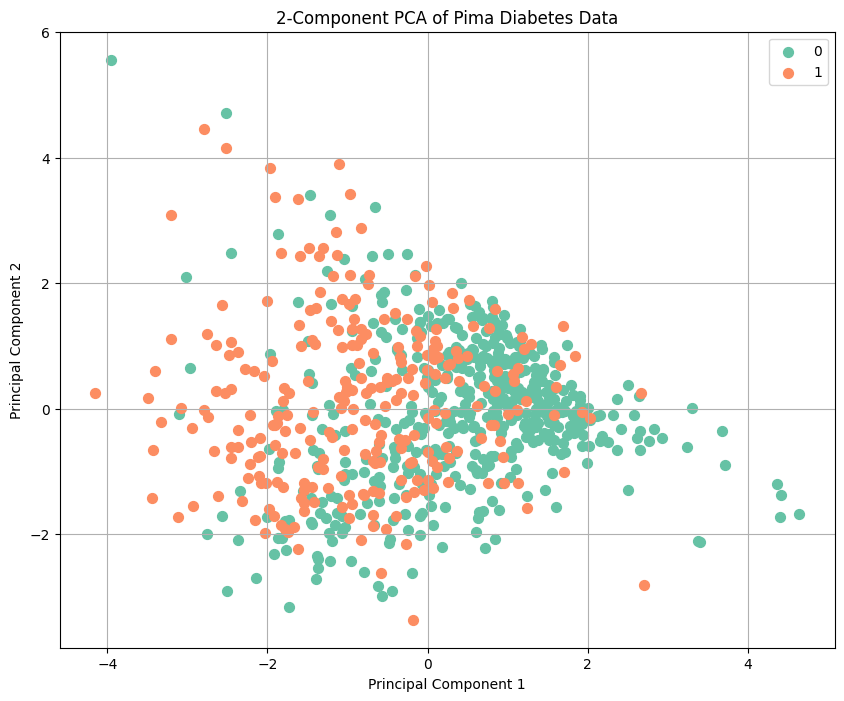

In [ ]:
# @title 2D PCA with All Features

# Get list of features
pca_attributes = list(pima_diabetes_df.columns)
pca_attributes.remove('Outcome')
pca_attributes.remove('SkinThickness')

# Separate features and target; standardize features
X = pima_diabetes_df.loc[:, pca_attributes].values
y = pima_diabetes_df.loc[:, ['Outcome']].values
x = StandardScaler().fit_transform(X)

# PCA Projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

pca_df = pd.DataFrame(data=principalComponents, columns=['Component 1', 'Component 2'])
pca_pima_df = pd.concat([pca_df, pima_diabetes_df[['Outcome']]], axis=1)

print(pca_pima_df)

# Visualize PCA of Pima Diabetes data
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2-Component PCA of Pima Diabetes Data')

outcomes = [0, 1]
colors = sns.color_palette("Set2", 2)

for outcome, color in zip(outcomes, colors):
    kept_indices = pca_pima_df['Outcome'] == outcome
    ax.scatter(pca_pima_df.loc[kept_indices, 'Component 1'],
               pca_pima_df.loc[kept_indices, 'Component 2'],
               c=color,
               s=50)
ax.legend(outcomes)
ax.grid()

pca.explained_variance_ratio_

Result of Principal Component Analysis:

Variance Ratio with all features analyzed:
0.26179749, 0.21640127 (Component 1, Component 2)

Variance Ratio with all features but Insulin:
0.2719368 , 0.22846055

Variance Ratio with all features but SkinThickness:
0.27442381, 0.21465747

Variance Ratio without Insulin or SkinThickness:
0.31073614, 0.21384448


## Feature Selection

In [ ]:
# Get list of features
attributes = list(pima_diabetes_df.columns)
attributes.remove('Outcome')

<ipython-input-35-6b78a3d444ce>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X, y)


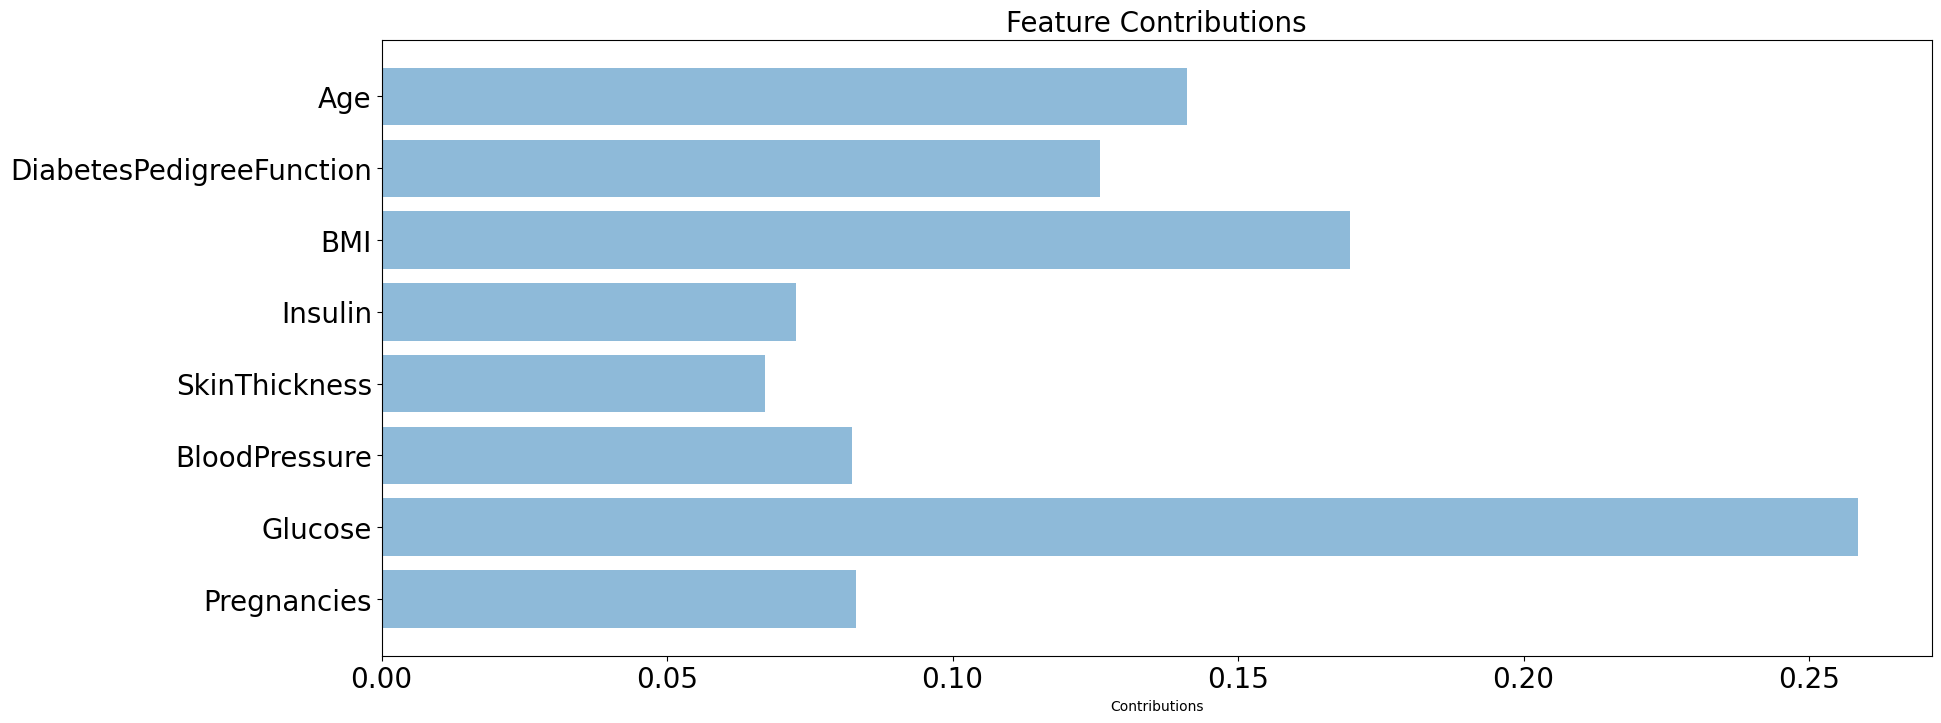

In [ ]:
# @title Random Forest for Importance of Features
rfc = RandomForestClassifier()

X = pima_diabetes_df.loc[:, attributes].values
y = pima_diabetes_df.loc[:, ['Outcome']].values

rfc.fit(X, y)
y_pos = np.arange(len(attributes))
importance = rfc.feature_importances_
performance = importance

fig, ax = plt.subplots(figsize=(20, 8))
plt.barh(y_pos, performance, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, attributes, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Contributions')
plt.title('Feature Contributions',fontsize=20)
plt.show()

<ipython-input-36-64b83e84f74f>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X, y)


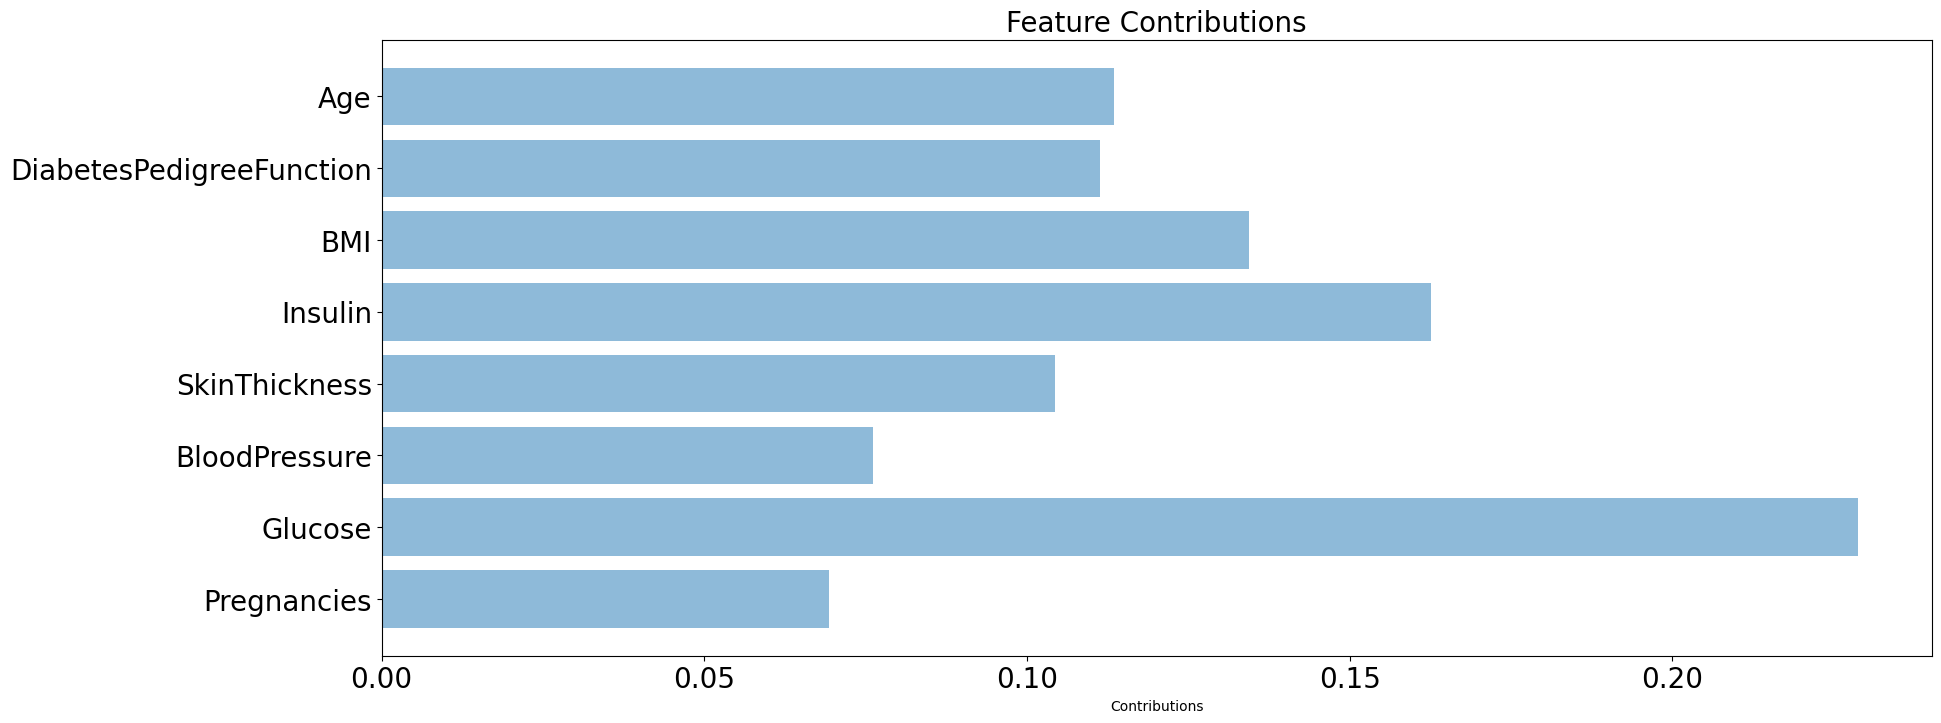

In [ ]:
# @title Random Forest Post-Imputation via KNN
rfc = RandomForestClassifier()

X = valid_pima_after_knn_df.loc[:, attributes].values
y = valid_pima_after_knn_df.loc[:, ['Outcome']].values

rfc.fit(X, y)
y_pos = np.arange(len(attributes))
importance = rfc.feature_importances_
performance = importance

fig, ax = plt.subplots(figsize=(20, 8))
plt.barh(y_pos, performance, align='center', alpha=0.5)
fontsize=14,
plt.yticks(y_pos, attributes, fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Contributions')
plt.title('Feature Contributions',fontsize=20)
plt.show()

Result of RFC:

Insulin and SkinThickness importance went up

Relevant to model, will keep both

<ipython-input-37-36d3243a192c>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_original.fit(X_original, y)
<ipython-input-37-36d3243a192c>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc_imputed.fit(X_imputed, y)


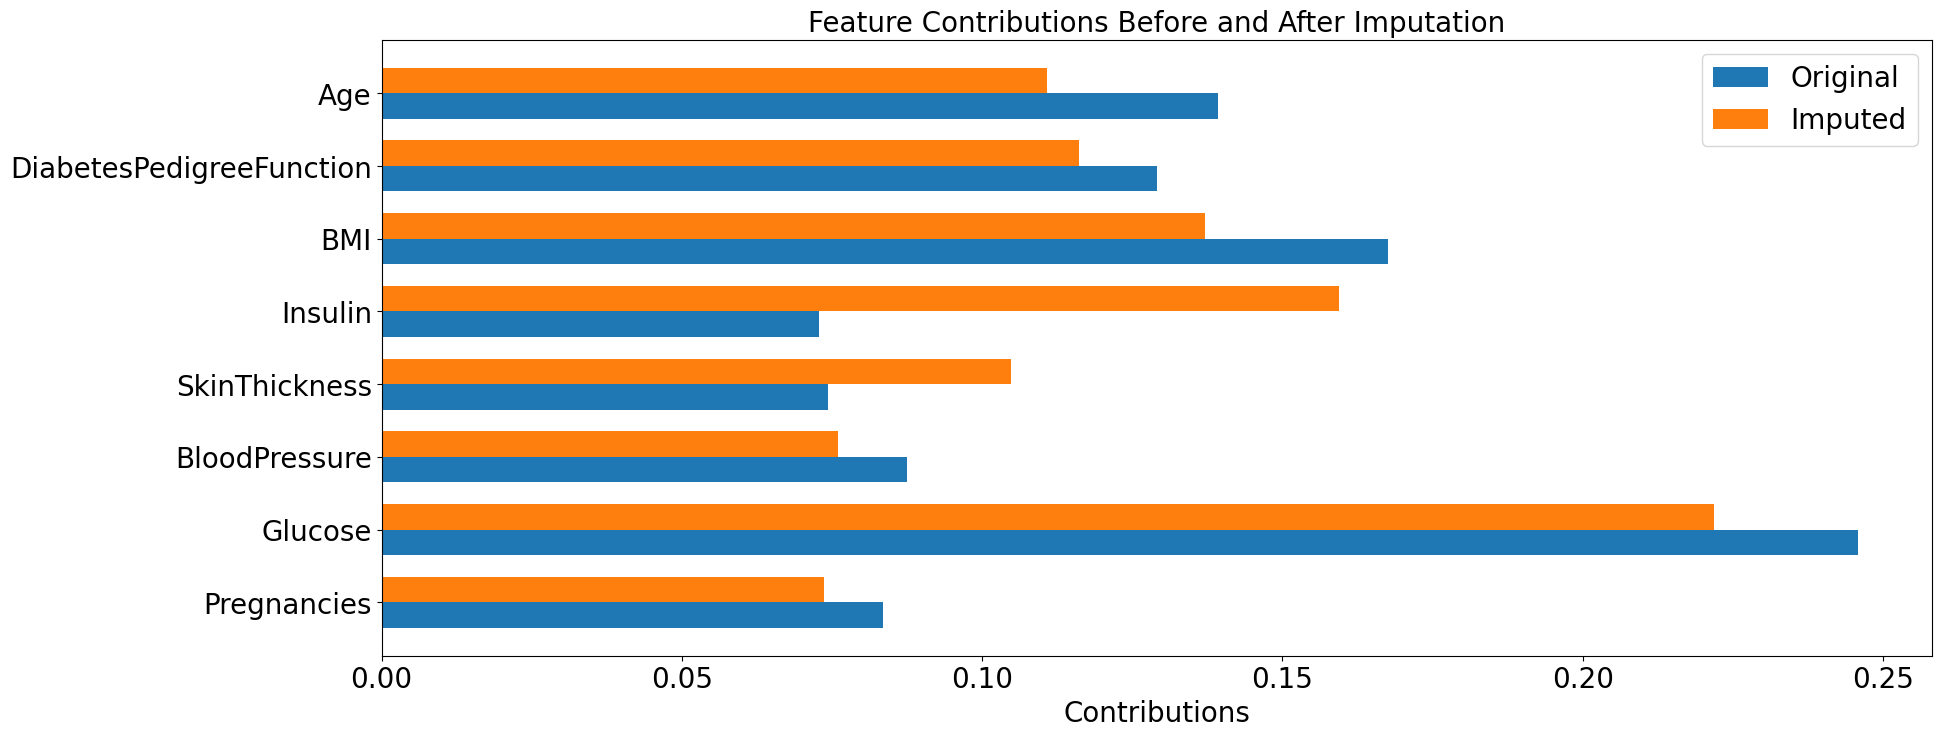

In [ ]:
X_original = pima_diabetes_df.loc[:, attributes].values
X_imputed = valid_pima_after_knn_df.loc[:, attributes].values
y = pima_diabetes_df.loc[:, ['Outcome']].values

rfc_original = RandomForestClassifier()
rfc_original.fit(X_original, y)
importance_original = rfc_original.feature_importances_

rfc_imputed = RandomForestClassifier()
rfc_imputed.fit(X_imputed, y)
importance_imputed = rfc_imputed.feature_importances_

y_pos = np.arange(len(attributes))
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(20, 8))
rects1 = ax.barh(y_pos - width/2, importance_original, width, label='Original')
rects2 = ax.barh(y_pos + width/2, importance_imputed, width, label='Imputed')

ax.set_xlabel('Contributions', fontsize=20)
ax.set_title('Feature Contributions Before and After Imputation', fontsize=20)
ax.set_yticks(y_pos)
ax.set_yticklabels(attributes, fontsize=20)
ax.legend(fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

## Random Sampling (With Imputation)

In [ ]:
# sample 50 times
sampled_datasets = []
insulin_sparsities = []
skin_thick_sparsities = []
total_sparsities = []
for i in range(50):
    sampled_df = valid_pima_df.sample(n=450, random_state=i)
    sampled_datasets.append(sampled_df)

    # calculate sparsities for the sampled sets
    total_vals = sampled_df.size
    missing_insulin = (sampled_df['Insulin'] == 0).sum().sum()
    missing_skin_thick = (sampled_df['SkinThickness'] == 0).sum().sum()
    total_missing = missing_insulin + missing_skin_thick
    sparsity_insulin = missing_insulin / sampled_df['Insulin'].size
    sparsity_skin_thick = missing_skin_thick / sampled_df['SkinThickness'].size
    total_sparsity = total_missing / total_vals
    insulin_sparsities.append(sparsity_insulin)
    skin_thick_sparsities.append(sparsity_skin_thick)
    total_sparsities.append(total_sparsity)

sampled_sparsity_df = pd.DataFrame({
    'Insulin Sparsity': insulin_sparsities,
    'SkinThickness Sparsity': skin_thick_sparsities,
    'Total Sparsity': total_sparsities
})

# print(sampled_datasets[0])
print(sampled_sparsity_df)

sparsity_insulin0 = (sampled_df['Insulin'] == 0).sum().sum() / valid_pima_df['Insulin'].size
sparsity_skin_thick0 = (sampled_df['SkinThickness'] == 0).sum().sum() / valid_pima_df['SkinThickness'].size
sparsity0 = ((sampled_df['Insulin'] == 0).sum().sum() + (sampled_df['SkinThickness'] == 0).sum().sum()) / valid_pima_df.size

originial_sparsity_df = pd.DataFrame([[sparsity_insulin0, sparsity_skin_thick0, sparsity0]],
                                     columns=['Orig Insulin Sparsity', 'Orig SkinThickness Sparsity', 'Orig Total Sparsity'])

print(originial_sparsity_df)

    Insulin Sparsity  SkinThickness Sparsity  Total Sparsity
0           0.513333                0.317778        0.092346
1           0.462222                0.286667        0.083210
2           0.491111                0.291111        0.086914
3           0.471111                0.286667        0.084198
4           0.508889                0.293333        0.089136
5           0.482222                0.295556        0.086420
6           0.480000                0.277778        0.084198
7           0.477778                0.277778        0.083951
8           0.471111                0.293333        0.084938
9           0.475556                0.280000        0.083951
10          0.506667                0.308889        0.090617
11          0.468889                0.293333        0.084691
12          0.515556                0.326667        0.093580
13          0.475556                0.297778        0.085926
14          0.482222                0.282222        0.084938
15          0.493333    

By comparing our original sparsities for insulin and skin thickness, we observe that our sparsities increased with sampling. This is because with a smaller sample size, we have a a more concentrated level of 0-values for these features.

# Model Construction and Evaluation

- pima_diabetes_df = original dataset
- valid_pima_after_knn_df = pima post imputation

## Model Selection

Can try both Random Forest + Bagged Decision Trees and see which one gives higher score in terms of confusion matrix on validation dataset

In [ ]:
def train_model(X, y, rf, num_folds=5):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  rf.fit(X_train, y_train)

  y_pred = rf.predict(X_test)
  y_prob = rf.predict_proba(X_test)[:, 1]

  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.title('Confusion Matrix')
  plt.show()

  fpr, tpr, _ = roc_curve(y_test, y_prob)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

  kf = KFold(n_splits=num_folds, shuffle=True)
  scores = cross_val_score(rf, X, y, cv=kf, scoring='accuracy')

  print("Cross-validation scores:", scores)
  print("Mean accuracy:", np.mean(scores))
  print("Standard deviation:", np.std(scores))

  print("Classification Report:")
  print(classification_report(y_test, y_pred))


  return rf


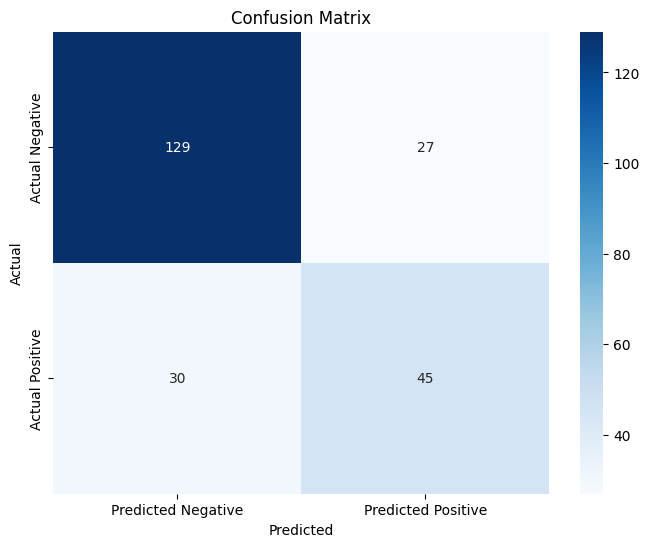

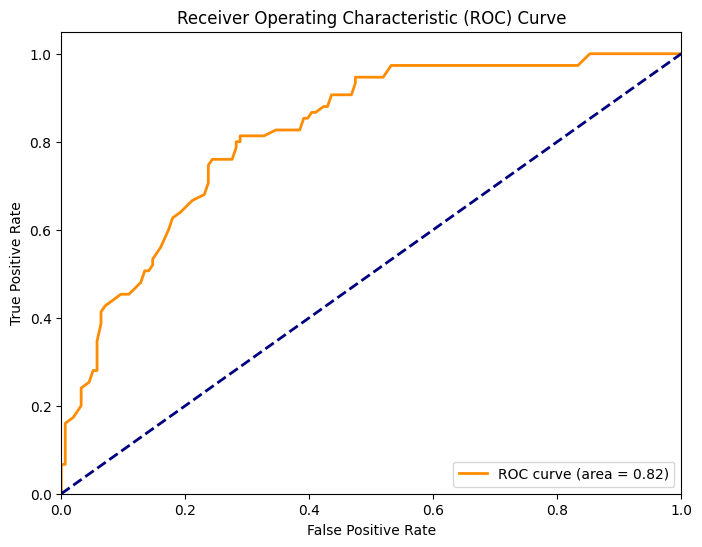

Cross-validation scores: [0.7012987  0.71428571 0.78571429 0.75816993 0.76470588]
Mean accuracy: 0.7448349036584331
Standard deviation: 0.031851080390080964
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       156
           1       0.62      0.60      0.61        75

    accuracy                           0.75       231
   macro avg       0.72      0.71      0.72       231
weighted avg       0.75      0.75      0.75       231



In [ ]:
# @title Original Dataset
X = valid_pima_after_knn_df.drop(columns=['Outcome'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

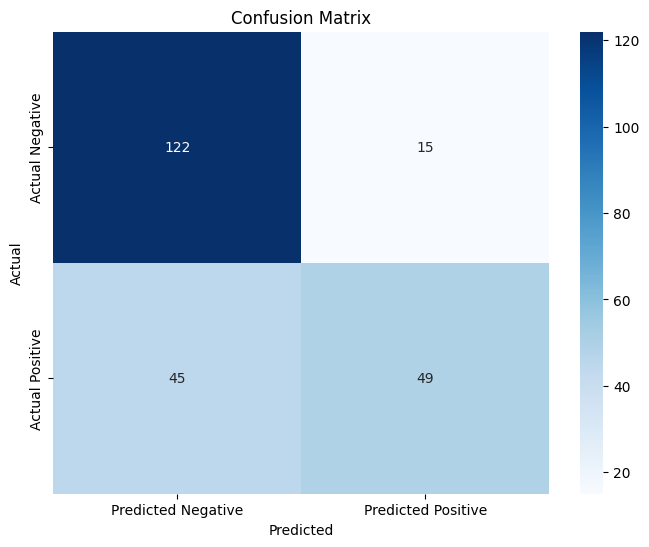

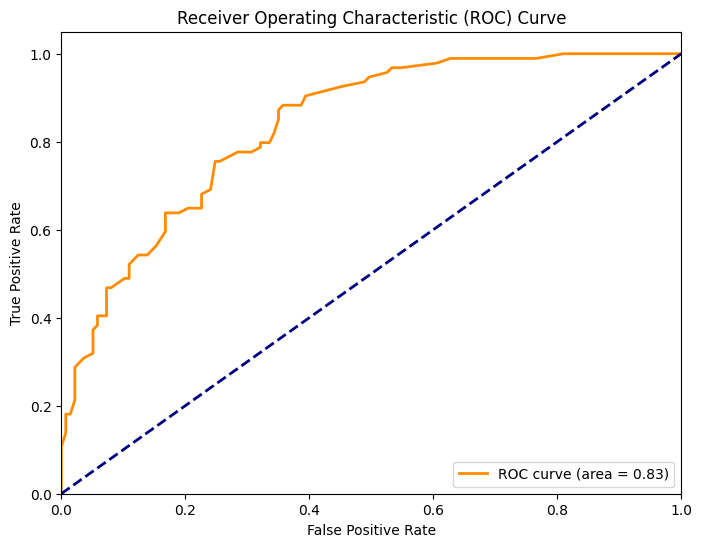

Cross-validation scores: [0.7987013  0.72077922 0.72727273 0.76470588 0.79738562]
Mean accuracy: 0.7617689500042442
Standard deviation: 0.03320035687564885
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       137
           1       0.77      0.52      0.62        94

    accuracy                           0.74       231
   macro avg       0.75      0.71      0.71       231
weighted avg       0.74      0.74      0.73       231



In [ ]:
# @title Imputed Dataset
X = valid_pima_after_knn_df.drop(columns=['Outcome'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

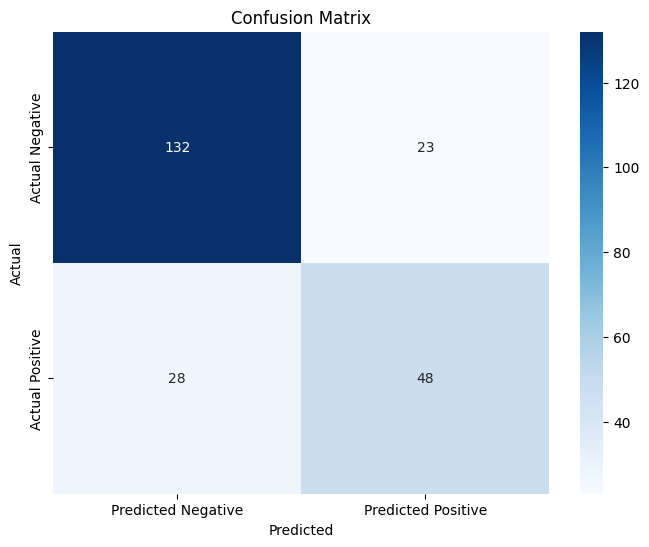

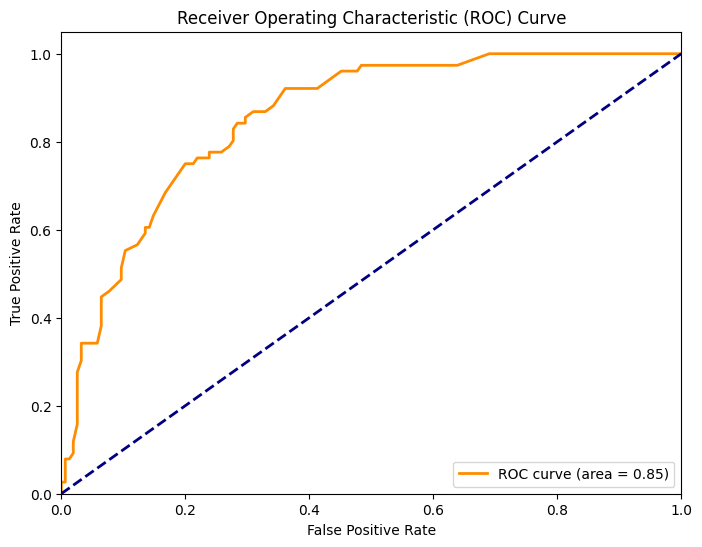

Cross-validation scores: [0.81168831 0.75974026 0.74025974 0.73202614 0.77777778]
Mean accuracy: 0.7642984466513878
Standard deviation: 0.02852237606040437
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       155
           1       0.68      0.63      0.65        76

    accuracy                           0.78       231
   macro avg       0.75      0.74      0.75       231
weighted avg       0.78      0.78      0.78       231



In [50]:
# @title Model Without Pregnancies
X = valid_pima_after_knn_df.drop(columns=['Outcome', 'Pregnancies'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

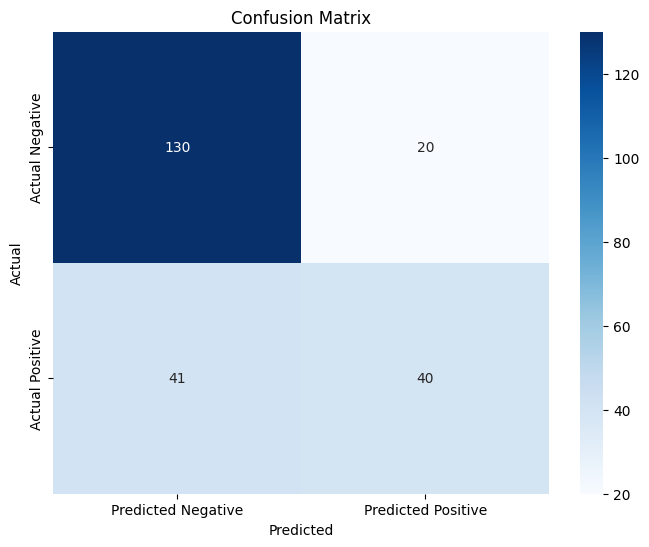

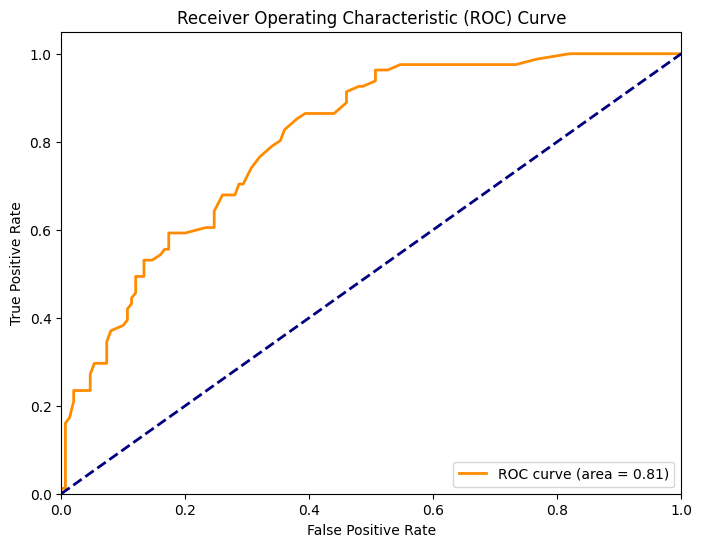

Cross-validation scores: [0.76623377 0.74025974 0.7987013  0.74509804 0.79084967]
Mean accuracy: 0.7682285035226212
Standard deviation: 0.02350130906164032
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       150
           1       0.67      0.49      0.57        81

    accuracy                           0.74       231
   macro avg       0.71      0.68      0.69       231
weighted avg       0.73      0.74      0.72       231



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# @title Model Without SkinThickness and Insulin (Downloaded Model)
X = valid_pima_after_knn_df.drop(columns=['Outcome', 'SkinThickness', 'Insulin'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

model_filename = 'pima_diabetes_model.pkl'
with open(model_filename, 'wb') as file:
  joblib.dump(basic_model, file)

files.download(model_filename)

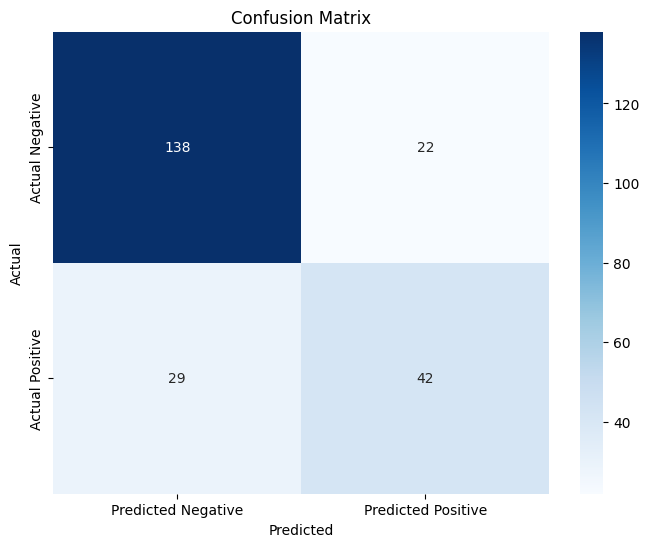

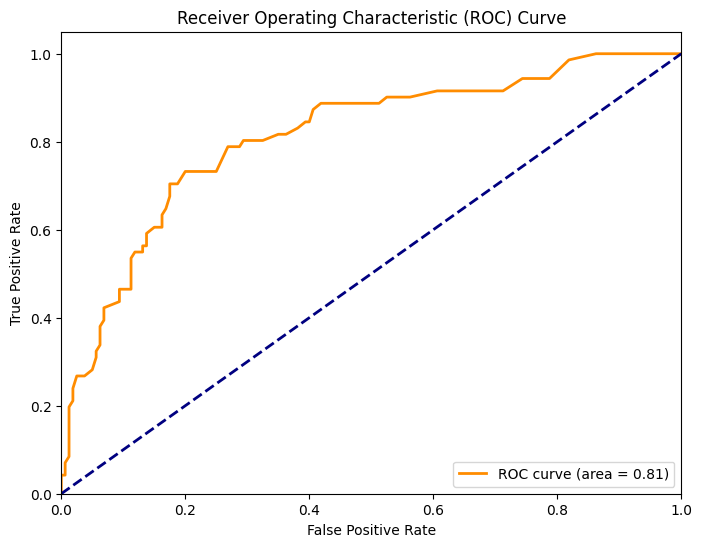

Cross-validation scores: [0.70779221 0.78571429 0.80519481 0.71895425 0.75163399]
Mean accuracy: 0.7538579067990833
Standard deviation: 0.0374047211754844
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       160
           1       0.66      0.59      0.62        71

    accuracy                           0.78       231
   macro avg       0.74      0.73      0.73       231
weighted avg       0.77      0.78      0.78       231



In [ ]:
# @title Model Without SkinThickness, Insulin, and Pregnancies
X = valid_pima_after_knn_df.drop(columns=['Outcome', 'SkinThickness', 'Insulin', 'Pregnancies'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

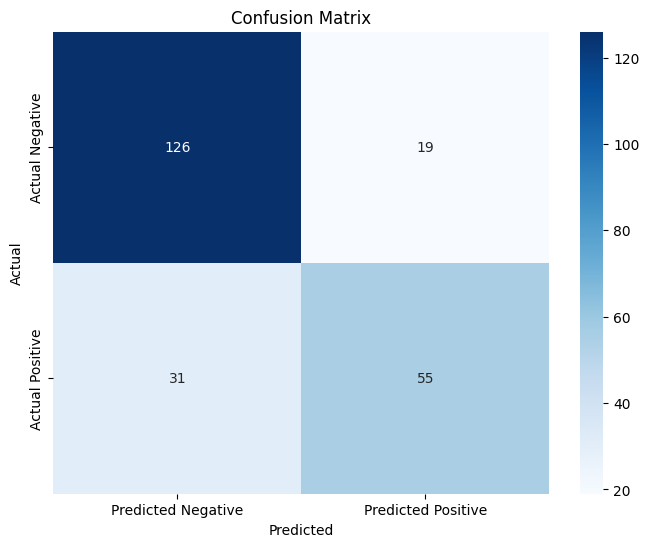

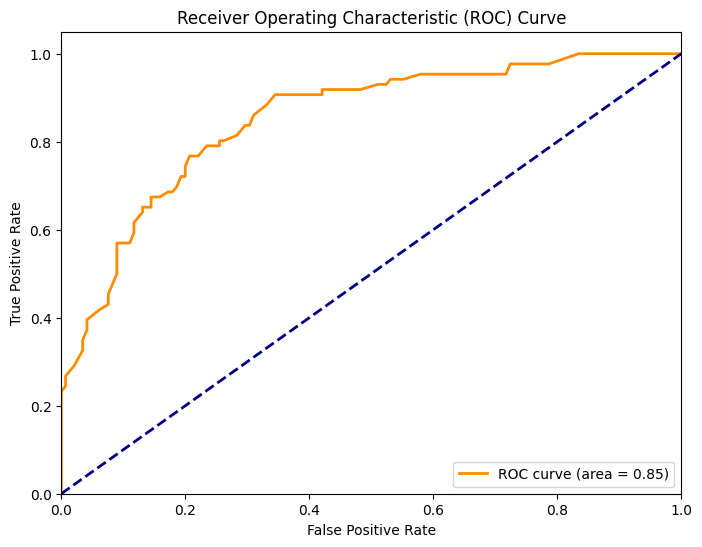

Cross-validation scores: [0.74025974 0.78571429 0.77272727 0.77124183 0.74509804]
Mean accuracy: 0.7630082335964689
Standard deviation: 0.017413130948018735
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       145
           1       0.74      0.64      0.69        86

    accuracy                           0.78       231
   macro avg       0.77      0.75      0.76       231
weighted avg       0.78      0.78      0.78       231



In [ ]:
# @title Model Without SkinThickness
X = valid_pima_after_knn_df.drop(columns=['Outcome', 'SkinThickness'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

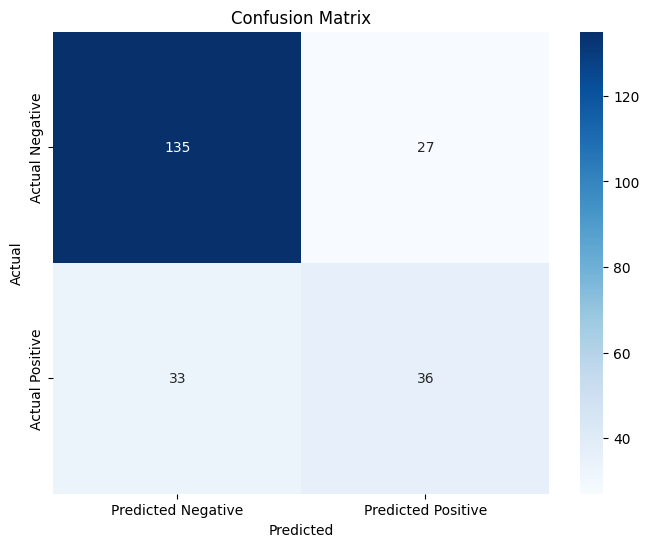

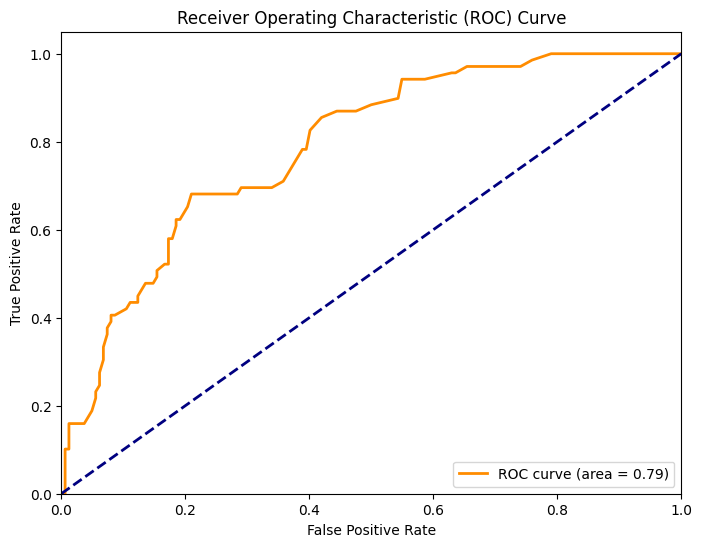

Cross-validation scores: [0.74675325 0.77272727 0.74675325 0.73856209 0.79084967]
Mean accuracy: 0.7591291061879296
Standard deviation: 0.019598114151611425
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       162
           1       0.57      0.52      0.55        69

    accuracy                           0.74       231
   macro avg       0.69      0.68      0.68       231
weighted avg       0.73      0.74      0.74       231



In [ ]:
# @title Model Without Insulin
X = valid_pima_after_knn_df.drop(columns=['Outcome', 'Insulin'])
y = valid_pima_after_knn_df['Outcome']

rfc = RandomForestClassifier(n_estimators=100)
basic_model = train_model(X, y, rfc)

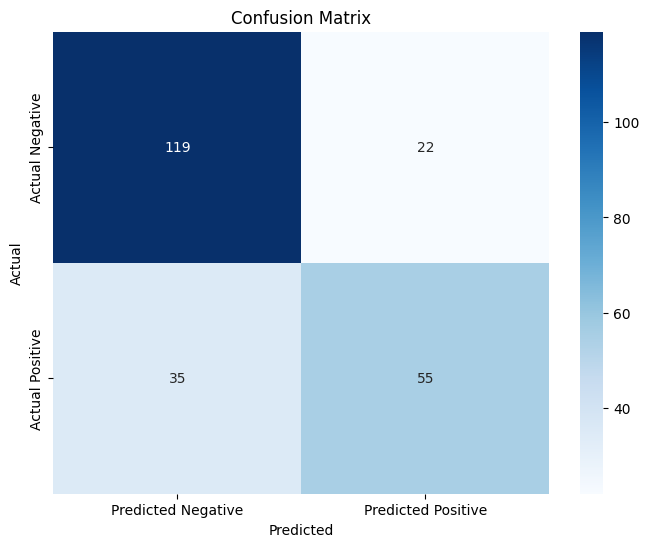

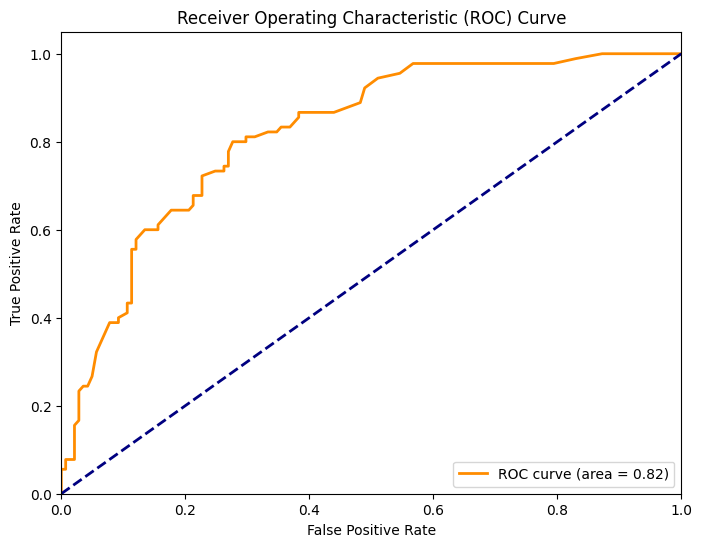

Cross-validation scores: [0.75974026 0.78571429 0.72077922 0.73856209 0.74509804]
Mean accuracy: 0.749978779390544
Standard deviation: 0.021813250655957336
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.84      0.81       141
           1       0.71      0.61      0.66        90

    accuracy                           0.75       231
   macro avg       0.74      0.73      0.73       231
weighted avg       0.75      0.75      0.75       231



In [ ]:
# @title Bagged Decision Tree Model Without SkinThickness and Insulin
X = valid_pima_after_knn_df.drop(columns=['Outcome', 'SkinThickness', 'Insulin'])
y = valid_pima_after_knn_df['Outcome']

dt = DecisionTreeClassifier()
bagc = BaggingClassifier(estimator=dt, n_estimators=100)
basic_model = train_model(X, y, bagc)